In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pymysql
import pylab as pl
import numpy as np
import pandas as pd
import os
import csv
from gcloud import storage
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import json
from decimal import Decimal
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud 
import math, re, string, requests, json
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
plt.rcParams['figure.figsize'] = (30, 6)
from afinn import Afinn
afinn=Afinn()

C:\Users\nehah\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Connect to the database.
connection = pymysql.connect(host='127.0.0.1',
                             user='root',
                             password='neha',                             
                             db='simpsons',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
 
print ("connect successful!!")

connect successful!!


In [4]:
#Load Data from Database into dataframes

df_characters = pd.read_sql("select  * from characters",con=connection);
df_locations=pd.read_sql("select  * from locations",con=connection);
df_episodes=pd.read_sql("select  * from episode",con=connection);
df_script_lines=pd.read_sql("select  * from script_lines",con=connection);


In [5]:
def stem_text(normalized_text):
    stem=[stemmer.stem(word) for word in normalized_text.split(' ')]
    return ' '.join(stem)

In [6]:
print(stem_text("ooo careful homer"))

ooo care homer


In [7]:
def clean_text(normalized_text):
    nopunc = [char for char in normalized_text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    list_without_stopwords = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return ' '.join(list_without_stopwords)



Stemming

In [8]:
df_script_lines['normalized_text'] = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in df_script_lines['normalized_text']]

df_script_lines['normalized_text'].head(10)

0                                                   []
1                                                   []
2                                   [ooo, care, homer]
3                      [there, no, time, to, be, care]
4                                         [were, late]
5                                                   []
6                                                   []
7                       [sorri, excus, us, pardon, me]
8    [hey, norman, how, it, go, so, you, got, drag,...
9                                 [pardon, my, galosh]
Name: normalized_text, dtype: object

After reading the reviews an analyzing the imdb ratings, I found that episode number 24 - "One Fish, Two Fish, Blowfish, Blue Fish" was one of  the most emotional epsiode of the series.
So I decided to analyze the sentiments in that episode 

Sentiment Analysis for Episode "One Fish, Two Fish, Blowfish, Blue Fish"

In [9]:
df_characters_from_episode_24=pd.read_sql("select episode_id, character_name, count(normalized_text) from(select distinct season,episode_id,character_id,character_name, Script_Lines.normalized_text from Script_Lines inner join Characters on Characters.id=Script_Lines.character_id inner join Episode on Episode.id=Script_Lines.episode_id  where Script_Lines.episode_id =24) as temp group by episode_id, character_name order by 3 desc", con=connection)

Fetch Dialogues for this epsiode

In [10]:
df_24_dialogues=pd.read_sql("Select episode_id,character_id,location_id,normalized_text, raw_character_text, raw_location_text from script_lines where episode_id=24 and character_id is not null and speaking_line='True'" , con=connection)

In [11]:
df_24_dialogues.head()

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text
0,24,2,140,is it done yet is it done yet,Homer Simpson,Simpson Kitchen
1,24,1,140,your meatloaf will be ready in eight seconds h...,Marge Simpson,Simpson Kitchen
2,24,2,140,isnt there anything faster than a microwave fo...,Homer Simpson,Simpson Kitchen
3,24,2,140,we have meatloaf,Homer Simpson,Simpson Kitchen
4,24,1,140,get it while its unbelievably hot kids,Marge Simpson,Simpson Kitchen


In [12]:
df_24_dialogues['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_24_dialogues['normalized_text']] 

In [13]:
df_24_dialogues['normalized_text_stem'].head()

0                        is it done yet is it done yet
1    your meatloaf will be readi in eight second homer
2    isnt there anyth faster than a microwav four t...
3                                     we have meatloaf
4                     get it while it unbeliev hot kid
Name: normalized_text_stem, dtype: object

In [14]:
all_words=[" ".join(df_24_dialogues['normalized_text_stem'])]

In [15]:
all_words=clean_text(all_words)

In [16]:
def removeDuplicates(all_words):
    
    result=[]
    seen=set()
    for char in all_words.split():
        if char not in seen:
            seen.add(char)
            result.append(char)
    return ' '.join(result)

In [17]:
all_words=removeDuplicates(all_words)

In [18]:
all_words

'done yet meatloaf readi eight second homer isnt anyth faster microwav four three two one ping get unbeliev hot kid yum ive got dri end-piec name lisa thursday -- night wa ever shall well alway tri teach opened-mind new thing live life talk nobodi shut boy mayb right tomorrow might nice go dinner friday pork chop marg havent miss sinc great pig scare 87 cradl grave etch stone god librari somewher okay want anywher hamburg pizza fri chicken fine mar sushi restaur elm street hey thi hear playground raw fish usual ha fact point entir consid quit delicaci pleas cant dad argument humili us said first time make think im gonna say ye noth ninety-ninth oh dadpleas irashiya alarm chef hello kariok bar empti soon hop drunken japanes businessmen akira waiter may take order would recommend famili sure sampler littl bit everyth veri non-threaten ill good man id like shark octopu eel ani giant squid kind drag men death today sir hard choos look terribl bring master toshiro hack blind woodsman hang h

Above are the words used in episode number 24. Analyzing the words will help us during the dictionery creation

The sentiment scores for the important words in the epsiode were stored in a csv file and will be using this file for the sentiment calculation

In [19]:
df_24_dialogues['normalized_text_stem'].head()

0                        is it done yet is it done yet
1    your meatloaf will be readi in eight second homer
2    isnt there anyth faster than a microwav four t...
3                                     we have meatloaf
4                     get it while it unbeliev hot kid
Name: normalized_text_stem, dtype: object

Result using already present libraries

In [20]:
def text_to_sentiment_score(text):
    return afinn.score(text)

In [21]:
df_24_dialogues['sentiment_score'] =  df_24_dialogues['normalized_text_stem'].map(text_to_sentiment_score)

In [22]:
df_24_dialogues=df_24_dialogues.sort_values(by=['sentiment_score'], ascending=False)

In [23]:
df_24_dialogues.head(5)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
143,24,2,43,shut up bart this is good stuff i want to shar...,Homer Simpson,Bart's Bedroom,shut up bart thi is good stuff i want to share...,10.0
258,24,2,5,love you love you love you,Homer Simpson,Simpson Home,love you love you love you,9.0
275,24,364,5,shallum begat hilkiah and hilkiah begat azaria...,LARRY KING V.O.,Simpson Home,shallum begat hilkiah and hilkiah begat azaria...,8.0
263,24,1,5,soon the rain will fall my dear one is departi...,Marge Simpson,Simpson Home,soon the rain will fall my dear one is depart ...,8.0
221,24,1,5,because sometimes its fun to use the good china,Marge Simpson,Simpson Home,becaus sometim it fun to use the good china,7.0


In [24]:
df_24_dialogues.tail(5)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
82,24,356,294,yes yes it is poisonous potentially fatal but ...,Akira,The Happy Sumo,ye ye it is poison potenti fatal but if slice ...,-5.0
284,24,33,5,strike thats two in a row lets see that one ag...,Announcer,Simpson Home,strike that two in a row let see that one agai...,-5.0
207,24,2,302,wait i cant call marge its our last day on ear...,Homer Simpson,Jail,wait i cant call marg it our last day on earth...,-5.0
243,24,17,15,oh wait a minute listen you little scum-suckin...,Moe Szyslak,Moe's Tavern,oh wait a minut listen you littl scum-suck pus...,-6.0
106,24,2,297,oh marge im gonna die im gonna die,Homer Simpson,Hospital,oh marg im gonna die im gonna die,-6.0


In [27]:
file = open("C:/Users/nehah/Desktop/Simpsons Project/Datasets/Simpsons Lexicon.csv","r")
lex_dict = {}
for line in file:
    (word, measure) = line.strip().split(',')[0:2]
    lex_dict[word] = float(measure)


In [28]:
#Logic for score calculation

In [29]:
# definig constants

B_INCR = 0.293
B_DECR = -0.293
N_SCALAR = -0.74

NEGATE = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
 "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
 "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
 "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
 "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
 "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
 "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
 "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

SPECIAL_CASE_IDIOMS = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "yeah right": -2,
                        "kiss of death": -1.5, "shut your mouth": -2, "hang your head": -2,
                       "you jerk": -2.5, "dee-lish": 2,"black private dick":-4, "damn right": 3,
                      "shut up": -1.5}

BOOSTER_DICT = \
{"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, "completely": B_INCR, "considerably": B_INCR,
 "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormously": B_INCR,
 "entirely": B_INCR, "especially": B_INCR, "exceptionally": B_INCR, "extremely": B_INCR,
 "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR,
 "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, "fucking": B_INCR,
 "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, "incredibly": B_INCR,
 "intensely": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
 "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
 "so": B_INCR, "substantially": B_INCR,
 "thoroughly": B_INCR, "totally": B_INCR, "tremendously": B_INCR,
 "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utterly": B_INCR,
 "very": B_INCR,
 "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
 "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
 "less": B_DECR, "little": B_DECR, "marginally": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
 "scarcely": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
 "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR,
"unbeliev": B_INCR , "better":B_INCR ,"great": B_INCR }



In [30]:
def scalar_inc_dec(word, valence):
   
    scalar = 0.0
    
    if word in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word]
        if valence < 0:
            scalar *= -1
   
    return scalar

The scalar function is written to boost the positive or negative sentiment if any booster words are present in the dialogue like amazingly or absolutely and so on.
The use of this function is to boost a sentiment  like  amazingly pretty will have more postive score than just pretty  because of the booster word used

In [31]:
def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i-1] != "at":
            return True
    return False

def _never_check(valence, words, start_i, i):
        if start_i == 0:
            if negated([words[i-1]]):
                    valence = valence*N_SCALAR
        return valence

This function will negate the sentiment of the context if any negation words are found in the sentence like if there is a sentence 'This isnt beautiful'. Even when 'beautiful' has a positive sentiment but the overall context of the sentence is expected to be negative. The negative function will do this fucntion 

In [32]:
def _least_check(valence, words, i):
        # check for negation case using "least"
        if i > 1 and words[i-1].lower() not in lex_dict \
           and words[i-1].lower() == "least":
            if words[i-2].lower() != "at" and words[i-2].lower() != "very":
                valence = valence*N_SCALAR
        elif i > 0 and words[i-1].lower() not in lex_dict \
             and words[i-1].lower() == "least":
            valence = valence*N_SCALAR
        return valence


This function will check for negation case using "least". Least is not negative in all cases but if used with 'at' or 'very' preceeding it will show a decrease the positivity or negativity of the sentiment


In [33]:
def _but_check(words, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        if 'but' in words or 'BUT' in words:
            try:
                bi = words.index('but')
            except ValueError:
                bi = words.index('BUT')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment*0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment*1.5)
        return sentiments
    

This But check funtion is written for contrastive conjuntion issue.
Like for the sentence "This is good but that is better" if the overall sentiment of the sentence before the conjunction is positive or negative, it will reevaluate the sentence depedning upon the seniment of the sentence after the conjuntion.
If its positive + 'but'+ positive= positive
If its Negative + 'but'+ negtive= negative

In [34]:
def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score/math.sqrt((score*score) + alpha)
    if norm_score < -1.0: 
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score

def _sift_sentiment_scores(sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) +1) # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) -1) # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

In [35]:
def sentiment_valence(valence,item, i, sentiments,words):
        
        if item in lex_dict:
            #get the sentiment valence
            valence = lex_dict[item]

            for start_i in range(0,3):
                if i > start_i and words[i-(start_i+1)].lower() not in lex_dict:
                    # dampen the scalar modifier of preceding words
                    # (excluding the ones that immediately preceed the item) based
                    # on their distance from the current item.
                    #print(i)
                    s = scalar_inc_dec(words[i-(start_i+1)], valence)
                    if start_i == 1 and s != 0:
                        s = s*0.95
                    if start_i == 2 and s != 0:
                        s = s*0.9
                    valence = valence+s
                    #print(valence)
                    valence = _never_check(valence, words, start_i, i)
                    #if start_i == 2:
                        #valence = _idioms_check(valence, words, i)
                        
            valence = _least_check(valence, words, i)

        sentiments.append(valence)
        return sentiments

In [36]:
def score_valence(sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))

            compound = normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = _sift_sentiment_scores(sentiments)

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg" : round(neg, 3),
             "neu" : round(neu, 3),
             "pos" : round(pos, 3),
             "compound" : round(compound, 4)}

        return sentiment_dict

The above function is used to sum up the overall positivity , negativity and neutrality of the sentence and the overall score

In [37]:
def polarity_scores(text):
    #text=clean_text(text)
    
    sentiments = []
    words=text.split()
    #words=[stemmer.stem(word) for word in words]
    for item in words:
        valence=0
        i=words.index(item)
        #print(i)
        sentiments = sentiment_valence(valence,item, i, sentiments,words)
        sentiments = _but_check(words, sentiments)
    valence_dict = score_valence(sentiments, text)

    return valence_dict['compound']

Trying out to check the accuracy of the scores 

In [38]:
score=polarity_scores('dyin')
print(score)

-0.7003


sentence with booster

In [39]:
score=polarity_scores('you better be dyin')
print(score)

-0.4404


In [40]:
score=polarity_scores('well maybe lisas right tomorrow night it might be nice to go out for dinner')
print(score)

0.5994


In [41]:
score=polarity_scores('nice')
print(score)

0.4215


The score here is because of the positive word nice. Since there are no other words affecting its sentiment, the overal score is equal to the score of the word

In [42]:
score=polarity_scores('tomorrow night friday pork chop night marge we havent missed pork chop night since the great pig scare in 87')
print(score)

0.4191


In [43]:
score=polarity_scores('we havent missed')
print(score)

0.2235


In [44]:
score=polarity_scores('we havent missed pork chop night since the great pig scare in 87')
print(score)

0.4191


In [45]:
score=polarity_scores('great')
print(score)

0.6249


In [46]:
score=polarity_scores('scare')
print(score)

-0.4939


In [47]:
score=polarity_scores('The great pig scare')
print(score)

0.2263


This score seems to be incorrect because of the positive sentiment given to the 'great' word.
The phrase 'Great pig scare' seems that there was a great scare and should be kind of negative scored.
We can resolve this by adding great as a booster word and check the score.

In [48]:
#Re-executed after updating the BOOSTER_DICT

In [49]:
score=polarity_scores('The great pig scare')
print(score)

0.2263


Well, this give somewhat expected results!!

May be adding great to booster dict may cause issues in other context.

We will check that in the later part

Starting with the sentiment scoring of the entire episode

In [50]:
file = open("C:/Users/nehah/Desktop/Simpsons Project/Datasets/episode_24_lexicon.csv","r")
lex_dict = {}
for line in file:
    (word, measure) = line.strip().split(',')[0:2]
    lex_dict[word] = float(measure)

In [51]:
df_24_dialogues1=pd.read_sql("Select episode_id,character_id,location_id,normalized_text, raw_character_text, raw_location_text from script_lines where episode_id=24 and character_id is not null and speaking_line='True'" , con=connection)
df_24_dialogues1['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_24_dialogues1['normalized_text']]
df_24_dialogues1['normalized_text_stem'].head()

0                        is it done yet is it done yet
1    your meatloaf will be readi in eight second homer
2    isnt there anyth faster than a microwav four t...
3                                     we have meatloaf
4                     get it while it unbeliev hot kid
Name: normalized_text_stem, dtype: object

In [52]:
df_24_dialogues1['sentiment_score'] =  df_24_dialogues1['normalized_text_stem'].map(polarity_scores)
df_24_dialogues1=df_24_dialogues1.sort_values(by=['sentiment_score'], ascending=False)
df_24_dialogues1.head(5)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
245,24,2,15,guys keep it down i got some last words i neve...,Homer Simpson,Moe's Tavern,guy keep it down i got some last word i never ...,1.0000
263,24,1,5,soon the rain will fall my dear one is departi...,Marge Simpson,Simpson Home,soon the rain will fall my dear one is depart ...,0.9993
169,24,2,25,this is a videotape for my daughter maggie hi ...,Homer Simpson,Simpson Living Room,thi is a videotap for my daughter maggi hi mag...,0.9411
258,24,2,5,love you love you love you,Homer Simpson,Simpson Home,love you love you love you,0.9382
221,24,1,5,because sometimes its fun to use the good china,Marge Simpson,Simpson Home,becaus sometim it fun to use the good china,0.8360


In [53]:
df_24_dialogues1.tail(5)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
99,24,2,297,try something new homer whatll it hurt you hom...,Homer Simpson,Hospital,tri someth new homer whatll it hurt you homer ...,-0.8625
89,24,357,294,poison poison tasty fish,Toshiro,The Happy Sumo,poison poison tasti fish,-0.8807
106,24,2,297,oh marge im gonna die im gonna die,Homer Simpson,Hospital,oh marg im gonna die im gonna die,-0.8910
77,24,8,294,hes a complicated man but no one understands h...,Bart Simpson,The Happy Sumo,he a complic man but no one understand him but...,-0.9355
285,24,314,5,yeah it is far from over but uh his approach h...,Announcer #2,Simpson Home,yeah it is far from over but uh hi approach ha...,-0.9990


(-0.5, 499.5, 349.5, -0.5)

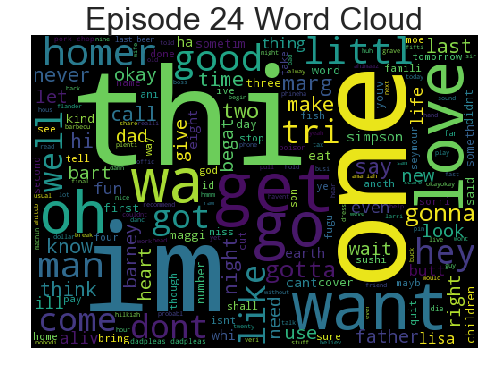

In [54]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_24_dialogues1.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text_stem'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Episode 24 Word Cloud', fontsize=32)
plt.axis("off")

Word Cloud for 10 most positive dialogues

In [55]:
df_24_dialogues_positive=df_24_dialogues1.head(15)

(-0.5, 499.5, 349.5, -0.5)

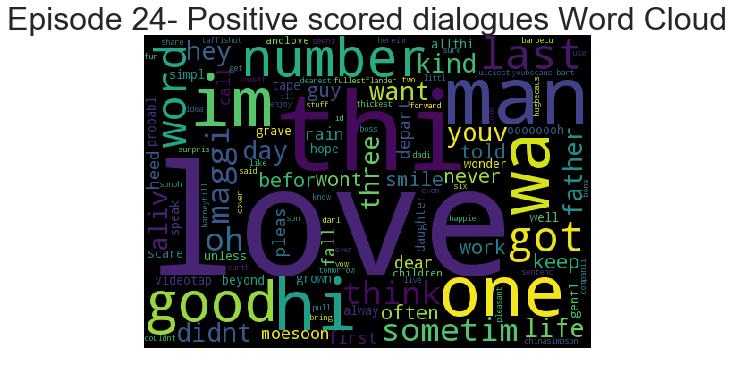

In [56]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_24_dialogues_positive.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text_stem'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Episode 24- Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Word Cloud for 10 most negative dialogues

In [57]:
df_24_dialogues_negative=df_24_dialogues1.tail(10)
#df_24_dialogues_negative

(-0.5, 499.5, 349.5, -0.5)

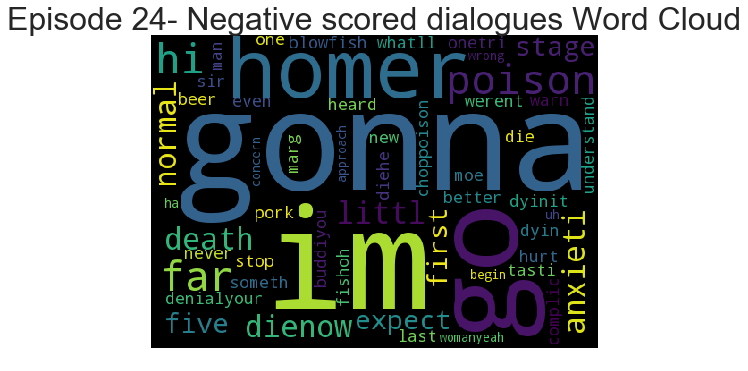

In [58]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_24_dialogues_negative.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text_stem'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Episode 24- Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Lets begin with sentiment scoring for all episodes

Load data for all epsiodes

In [59]:
df_all_epsiode_dialogues=pd.read_sql("Select episode_id,character_id,location_id,normalized_text, raw_character_text, raw_location_text from script_lines where character_id is not null and speaking_line='True'" , con=connection)

In [60]:
df_all_epsiode_dialogues.head()
df_all_epsiode_dialogues['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_all_epsiode_dialogues['normalized_text']]
all_words1=[" ".join(df_all_epsiode_dialogues['normalized_text_stem'])]

In [61]:
all_words1=clean_text(all_words1)
all_words1=removeDuplicates(all_words1)
all_words1

'ooo care homer time late sorri excus us pardon hey norman go got drag heh ya fred galosh wasnt wonder santa mani land present entir second grade class oh lisa frohlich weihnachten -- german merri christma germani servant ruprecht give good children whip rod parent bad one meri kurimasu hotseiosha japanes priest act like clau eye back head better behav im nearbi simpson tawanga south sea fourth favor melodi medley holiday flavorit dash snow one-hors open sleigh oer field laugh way ha bell bob-tail ring make spirit bright fun ride sing thi song tonight isnt bart sweet littl angel jingl batman smell robin laid egg batmobil broke wheel joker away fifth scene charl dicken carol doe school dear friend famili sad glad year first cat snowbal wa unexpectedli run went kitti heaven bought new iiso guess life goe speak grampa still feisti ever maggi walk straight well love magic season touch marg havent finish stupid letter yet send hi happi extens cord sake util drawer big kid much everi right l

The words obtained here were used to contruct the lexicon.
The lexicon was then scored as positive or negative and is now ready to be used for sentiment scoriing of dialogues

Loading the Lexicon

In [62]:
#C:\Users\nehah\Desktop\Simpsons Project\Datasets
file1 = open("C:/Users/nehah/Desktop/Simpsons Project/Datasets/Simpsons Lexicon.csv","r")
lex_dict = {}
for line in file1:
    (word, measure) = line.strip().split(',')[0:2]
    lex_dict[word] = float(measure)

In [63]:
df_all_epsiode_dialogues['sentiment_score'] =  df_all_epsiode_dialogues['normalized_text_stem'].map(polarity_scores)
df_all_epsiode_dialogues=df_all_epsiode_dialogues.sort_values(by=['sentiment_score'], ascending=False)


In [64]:
df_all_epsiode_dialogues.head(15)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
3156,12,153,196.0,this is all very exciting but i think wed do w...,Sideshow Bob,Sideshow Bob's Dressing Room,thi is all veri excit but i think wed do well ...,1.0
16373,63,210,5.0,but first lets join the new little miss spring...,Scott Christian,Simpson Home,but first let join the new littl miss springfi...,1.0
35431,146,139,5.0,well itchy and scratchy are gone but heres a c...,Krusty the Clown,Simpson Home,well itchi and scratchi are gone but here a ca...,1.0
35675,147,1923,1427.0,yeah but for a role like this you gotta pour i...,Macarthur Parker,TROY'S LIVING ROOM,yeah but for a role like thi you gotta pour it...,1.0
100864,425,11,904.0,wordplay never cared for it but its never too ...,Ned Flanders,FLANDERS CAR,wordplay never care for it but it never too so...,1.0
35769,148,38,1433.0,but surely i and my 600 could play some small ...,Martin Prince,STREET OUTSIDE MOE'S,but sure i and my 600 could play some small pa...,1.0
35927,148,2,10.0,uh you dont have to tell me but i thought we t...,Homer Simpson,Springfield Nuclear Power Plant,uh you dont have to tell me but i thought we t...,1.0
16184,62,140,5.0,no but he was working in the hearts of your fr...,Rev. Timothy Lovejoy,Simpson Home,no but he wa work in the heart of your friend ...,1.0
82190,338,1,5.0,bart have you ever eaten a tootsie pop you kno...,Marge Simpson,Simpson Home,bart have you ever eaten a tootsi pop you know...,1.0
36325,150,31,351.0,fellas its me sarge at ease i know im bendin t...,Grampa Simpson,Cemetery,fella it me sarg at eas i know im bendin the r...,1.0


In [65]:
df_all_epsiode_dialogues.tail(15)

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score
27514,111,9,1137.0,thats very nice dad but its wrong for you to r...,Lisa Simpson,SKATING RINK,that veri nice dad but it wrong for you to rew...,-1.0
98194,411,1,297.0,youre right but im worried about whats on the ...,Young Marge,Hospital,your right but im worri about what on the hori...,-1.0
12696,48,9,5.0,maybe not but i bet youre stupid enough to hav...,Lisa Simpson,Simpson Home,mayb not but i bet your stupid enough to have ...,-1.0
26098,104,8,1074.0,but i saw the murder and then i saw you bury t...,Bart Simpson,FLANDERS' FRONT YARD,but i saw the murder and then i saw you buri t...,-1.0
87790,363,192,1033.0,yeah but we dont sit around watching televisio...,Agnes Skinner,Springfield Streets,yeah but we dont sit around watch televis and ...,-1.0
108568,461,1,3733.0,i dont want to get homer in trouble but its ju...,Marge Simpson,SURVEILLANCE CENTER,i dont want to get homer in troubl but it just...,-1.0
94504,394,4912,3256.0,i have no friends friends take time and time i...,Tabloid Editor,TABLOID EDITOR'S OFFICE,i have no friend friend take time and time is ...,-1.0
5422,21,9,140.0,im sorry bart but if you got hurt or died desp...,Lisa Simpson,Simpson Kitchen,im sorri bart but if you got hurt or die despi...,-1.0
34774,143,139,408.0,no offense kid but your moms a dingbat theres ...,Krusty the Clown,Krusty's House,no offens kid but your mom a dingbat there no ...,-1.0
33043,135,2,332.0,this may surprise you but you cant buy me off ...,Homer Simpson,Aztec Theater,thi may surpris you but you cant buy me off wi...,-1.0


Word Cloud for 10 most positive dialogues

(-0.5, 499.5, 349.5, -0.5)

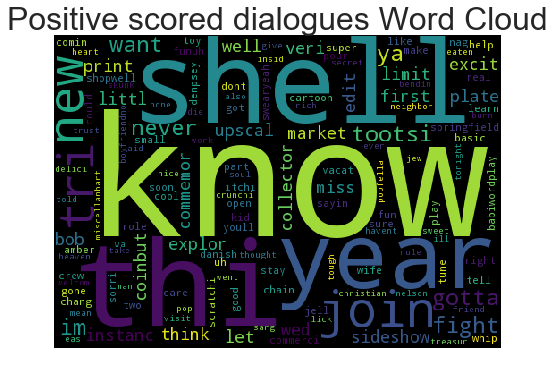

In [66]:
df_24_dialogues_positive_all=df_all_epsiode_dialogues.head(10)

my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_24_dialogues_positive_all.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text_stem'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")



Word Cloud for 10 most negative dialogues

(-0.5, 499.5, 349.5, -0.5)

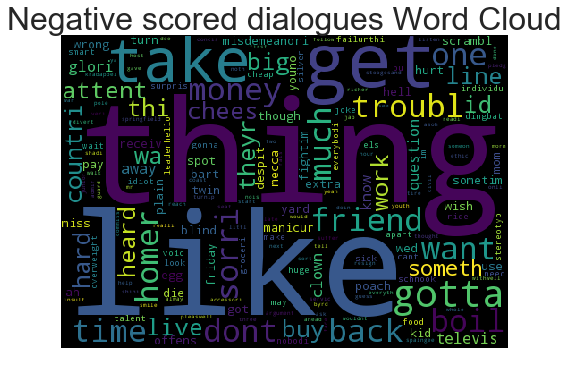

In [67]:

df_24_dialogues_negative_all=df_all_epsiode_dialogues.tail(10)
#df_24_dialogues_negative

my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_24_dialogues_negative_all.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text_stem'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Overall Sentiment Analysis of Simpsons family and some supporting characters

Homer Simpson

In [68]:
df_normalized_text = pd.read_sql("select raw_character_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Homer Simpson')",con=connection);
df_normalized_text ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text ['normalized_text']]
df_normalized_text ['sentiment_score'] =  df_normalized_text ['normalized_text_stem'].map(polarity_scores)
df_normalized_text=df_normalized_text.sort_values(by=['sentiment_score'], ascending=False)
df_normalized_text_positive=df_normalized_text.head(20)
df_normalized_text_positive

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
8430,Homer Simpson,you cant just kill off a classic tv character ...,you cant just kill off a classic tv charact po...,1.0
19964,Homer Simpson,look im sorry youre upset but if we tell the t...,look im sorri your upset but if we tell the tr...,1.0
7678,Homer Simpson,but youve got all the top bands in here styx i...,but youv got all the top band in here styx i j...,1.0
1108,Homer Simpson,whodve thought it a free ticket to a big leagu...,whodv thought it a free ticket to a big leagu ...,1.0
18935,Homer Simpson,look marge i know i was supposed to yell at th...,look marg i know i wa suppos to yell at that p...,1.0
8458,Homer Simpson,whoa not me and not because johns gay but beca...,whoa not me and not becaus john gay but becaus...,1.0
25968,Homer Simpson,marge youre really dogging it on the power but...,marg your realli dog it on the power but dont ...,1.0
18800,Homer Simpson,but sweetheart i have something they didnt hav...,but sweetheart i have someth they didnt have -...,1.0
9741,Homer Simpson,well im no margaret cho but i do a pretty fair...,well im no margaret cho but i do a pretti fair...,1.0
538,Homer Simpson,huh a very thoughtful gift but its a surprise ...,huh a veri thought gift but it a surpris you k...,1.0


(-0.5, 499.5, 349.5, -0.5)

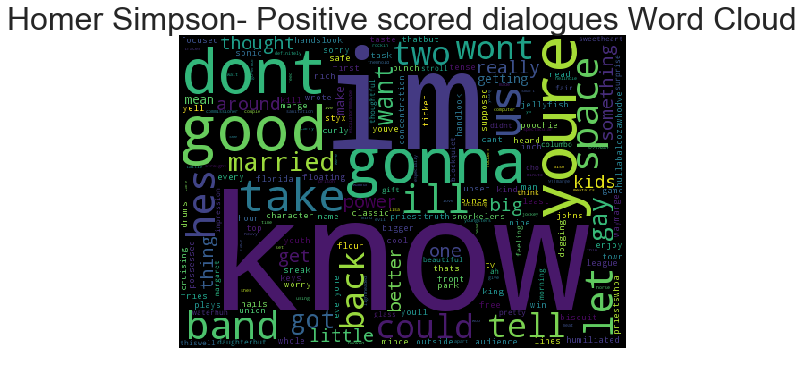

In [69]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_positive.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Homer Simpson- Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

In [70]:
df_normalized_text_negative=df_normalized_text.tail(20)
df_normalized_text_negative

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
3717,Homer Simpson,kids let me tell you about another so-called w...,kid let me tell you about anoth so-cal wick gu...,-1.0
21687,Homer Simpson,now lets think about this if you shoot me i wo...,now let think about thi if you shoot me i wont...,-1.0
10945,Homer Simpson,ladies we want to do the honorable thing so br...,ladi we want to do the honor thing so breakfas...,-1.0
554,Homer Simpson,you always say we should talk im talking right...,you alway say we should talk im talk right now...,-1.0
11191,Homer Simpson,and then the handsome prince realized he had t...,and then the handsom princ realiz he had to go...,-1.0
16353,Homer Simpson,now wait just a minute -- i used to worry marg...,now wait just a minut -- i use to worri marg w...,-1.0
26644,Homer Simpson,but when times seemed darkest one minute ago s...,but when time seem darkest one minut ago she w...,-1.0
22609,Homer Simpson,to-morrow and to-morrow and to-morrow creeps i...,to-morrow and to-morrow and to-morrow creep in...,-1.0
20761,Homer Simpson,i like that but im on a bit of a health kick s...,i like that but im on a bit of a health kick s...,-1.0
27338,Homer Simpson,well im no carl when it comes to this stuff bu...,well im no carl when it come to thi stuff but ...,-1.0


(-0.5, 499.5, 349.5, -0.5)

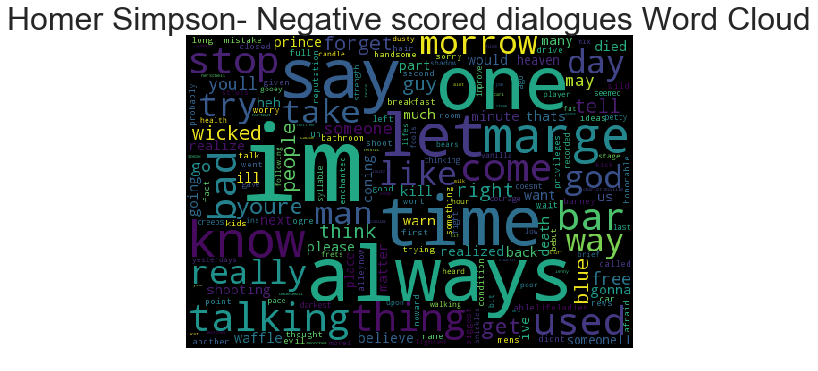

In [71]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_negative.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Homer Simpson- Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")	

Overall Sentiment Analysis for Marge Simpson

In [72]:
df_normalized_text1 = pd.read_sql("select raw_character_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Marge Simpson')",con=connection);
df_normalized_text1 ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text1 ['normalized_text']]
df_normalized_text1 ['sentiment_score'] =  df_normalized_text1 ['normalized_text_stem'].map(polarity_scores)
df_normalized_text1=df_normalized_text1.sort_values(by=['sentiment_score'], ascending=False)
df_normalized_text_positive1=df_normalized_text1.head(10)
df_normalized_text_positive1

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
4337,Marge Simpson,well i guess you were right honey but you have...,well i guess you were right honey but you have...,1.0
9207,Marge Simpson,lisa lots of times two incompatible things can...,lisa lot of time two incompat thing can both b...,1.0
1049,Marge Simpson,homer youre sneaking out to go fishing i cant ...,homer your sneak out to go fish i cant believ ...,1.0
8173,Marge Simpson,bart have you ever eaten a tootsie pop you kno...,bart have you ever eaten a tootsi pop you know...,1.0
10136,Marge Simpson,well um thanks but ive been wondering why do y...,well um thank but ive been wonder whi do you o...,1.0
4525,Marge Simpson,all right already but do you love the leader m...,all right alreadi but do you love the leader m...,1.0
9980,Marge Simpson,but our happiness was about to unravel just li...,but our happi wa about to unravel just like ke...,1.0
9931,Marge Simpson,i appreciate you trying to become more attract...,i appreci you tri to becom more attract for me...,1.0
5625,Marge Simpson,sweetie its nice that you want to take charge ...,sweeti it nice that you want to take charg aro...,1.0
1179,Marge Simpson,look i know bart can be a handful but i also k...,look i know bart can be a hand but i also know...,1.0


(-0.5, 499.5, 349.5, -0.5)

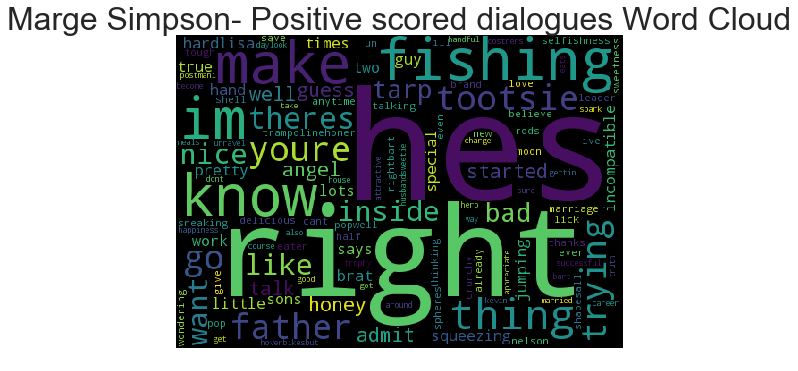

In [73]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_positive1.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Marge Simpson- Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

In [74]:
df_normalized_text_negative1=df_normalized_text1.tail(10)
df_normalized_text_negative1

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
12329,Marge Simpson,i know carl did you wrong but is destroying so...,i know carl did you wrong but is destroy somet...,-1.0
4112,Marge Simpson,well maybe but ill bet he would be less crazy ...,well mayb but ill bet he would be less crazi i...,-1.0
2843,Marge Simpson,sure okay ill talk about father father christm...,sure okay ill talk about father father christm...,-1.0
3766,Marge Simpson,but youre going to annoy thousands of people j...,but your go to annoy thousand of peopl just to...,-1.0
3283,Marge Simpson,id like to honey but im not sure how your fath...,id like to honey but im not sure how your fath...,-1.0
10923,Marge Simpson,i dont want to get homer in trouble but its ju...,i dont want to get homer in troubl but it just...,-1.0
4517,Marge Simpson,homer you know i always try to put the best fa...,homer you know i alway tri to put the best fac...,-1.0
11631,Marge Simpson,youre going with me but lisa after this i dont...,your go with me but lisa after thi i dont want...,-1.0
12211,Marge Simpson,not because of what you bought but because i r...,not becaus of what you bought but becaus i rea...,-1.0
10401,Marge Simpson,they say if you kiss the blarney stone you get...,they say if you kiss the blarney stone you get...,-1.0


(-0.5, 499.5, 349.5, -0.5)

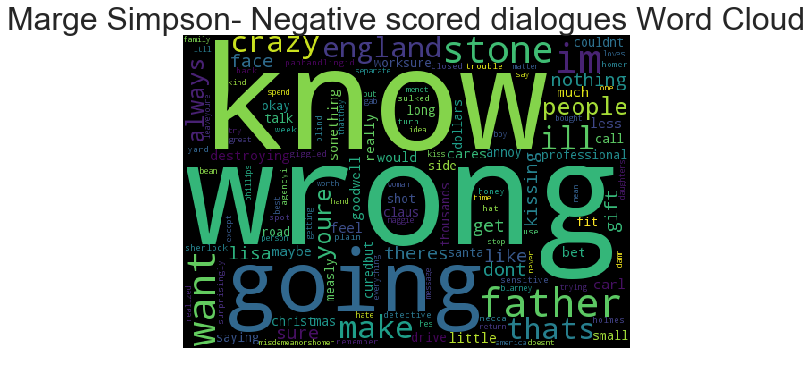

In [75]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_negative1.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Marge Simpson- Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Overall sentiment analysis for Bart Simpson

In [76]:
df_normalized_text2 = pd.read_sql("select raw_character_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Bart Simpson')",con=connection);
df_normalized_text2 ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text2 ['normalized_text']]
df_normalized_text2 ['sentiment_score'] =  df_normalized_text2 ['normalized_text_stem'].map(polarity_scores)
df_normalized_text2=df_normalized_text2.sort_values(by=['sentiment_score'], ascending=False)
df_normalized_text_positive2=df_normalized_text2.head(20)
df_normalized_text_positive2

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
4916,Bart Simpson,and i miss him so much and i know you like him...,and i miss him so much and i know you like him...,1.0
11598,Bart Simpson,but when the helpful voice was silent the dail...,but when the help voic wa silent the daili les...,1.0
4517,Bart Simpson,hes kidding mom but seriously id love to have ...,he kid mom but serious id love to have hair li...,1.0
5548,Bart Simpson,uh yeah but i have a certain respect for that ...,uh yeah but i have a certain respect for that ...,1.0
10832,Bart Simpson,bart im not thrilled either but one day we mig...,bart im not thrill either but one day we might...,1.0
11847,Bart Simpson,but the slides just like our cruise a short aw...,but the slide just like our cruis a short awes...,1.0
12011,Bart Simpson,yeah it was great this one guy was part of ano...,yeah it wa great thi one guy wa part of anoth ...,1.0
1282,Bart Simpson,but i must until this moment i never knew why ...,but i must until thi moment i never knew whi g...,1.0
4148,Bart Simpson,okay okay i wont bug milhouse but well mrs van...,okay okay i wont bug milhous but well mr van h...,1.0
4074,Bart Simpson,but you cant kill krusty he made you what you ...,but you cant kill krusti he made you what you ...,1.0


Word Cloud

(-0.5, 499.5, 349.5, -0.5)

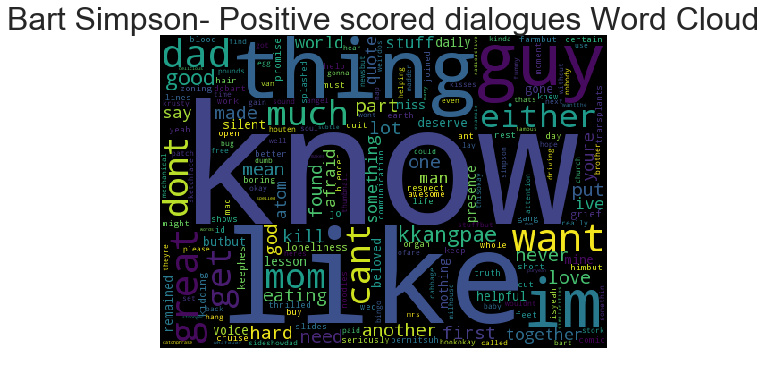

In [77]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_positive2.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Bart Simpson- Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

In [78]:
df_normalized_text_negative2=df_normalized_text2.tail(20)
df_normalized_text_negative2

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
5991,Bart Simpson,but goliath is dead i smote him myself i smote...,but goliath is dead i smote him myself i smote...,-0.9995
8892,Bart Simpson,no fair dad gets to kill wild animals but i sh...,no fair dad get to kill wild anim but i shoot ...,-0.9995
8649,Bart Simpson,i see you were mad enough to leave our house b...,i see you were mad enough to leav our hous but...,-0.9995
611,Bart Simpson,well maybe but get this krusty was illiterate ...,well mayb but get thi krusti wa illiter and th...,-0.9997
7963,Bart Simpson,but i miss being a regular kid in the real wor...,but i miss be a regular kid in the real world ...,-0.9999
3423,Bart Simpson,but stealing from the collection basket is rea...,but steal from the collect basket is realli wr...,-0.9999
5524,Bart Simpson,some say the ducks went to canada others say t...,some say the duck went to canada other say tor...,-0.9999
3913,Bart Simpson,but milhouse they havent cured anything heart ...,but milhous they havent cure anyth heart disea...,-1.0000
11091,Bart Simpson,but its not my fault youre leaving its yours b...,but it not my fault your leav it your becaus y...,-1.0000
11055,Bart Simpson,look i know youre cool now but my dad hates yo...,look i know your cool now but my dad hate you ...,-1.0000


(-0.5, 499.5, 349.5, -0.5)

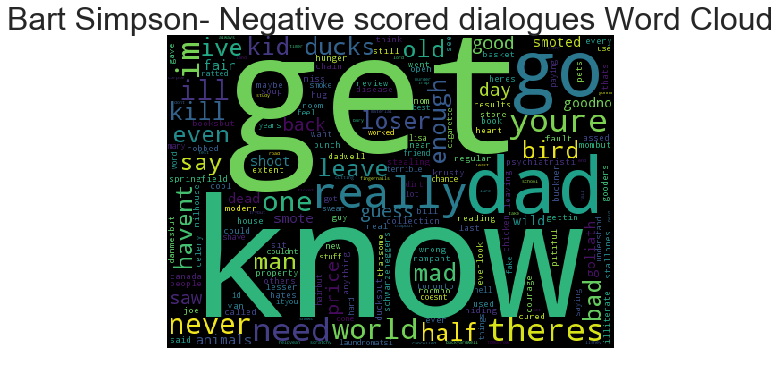

In [79]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_negative2.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Bart Simpson- Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Overall Sentiment Analysis for Lisa Simpson

In [80]:
df_normalized_text3 = pd.read_sql("select raw_character_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Lisa Simpson')",con=connection);
df_normalized_text3 ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text3 ['normalized_text']]
df_normalized_text3 ['sentiment_score'] =  df_normalized_text3 ['normalized_text_stem'].map(polarity_scores)
df_normalized_text3=df_normalized_text3.sort_values(by=['sentiment_score'], ascending=False)
df_normalized_text_positive3=df_normalized_text3.head(20)
df_normalized_text_positive3

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
3749,Lisa Simpson,well not literally but in a way isnt he everyo...,well not liter but in a way isnt he everyon so...,1.0
5757,Lisa Simpson,well barts being his usual jerky self but mom ...,well bart be hi usual jerki self but mom im re...,1.0
2644,Lisa Simpson,but when you found the truth you couldnt take ...,but when you found the truth you couldnt take ...,1.0
10167,Lisa Simpson,a gumbamels a camel but faster and humbler it ...,a gumbamel a camel but faster and humbler it d...,1.0
2939,Lisa Simpson,but i bet underneath hes a sweet sensitive per...,but i bet underneath he a sweet sensit person ...,1.0
10061,Lisa Simpson,milhouse im not sure why you left me in the fo...,milhous im not sure whi you left me in the for...,1.0
9988,Lisa Simpson,but i am playing im hop-scotching from paragra...,but i am play im hop-scotch from paragraph to ...,1.0
9736,Lisa Simpson,let me explain i have a chance for a grim but ...,let me explain i have a chanc for a grim but t...,1.0
9627,Lisa Simpson,thanks but i couldnt have done it mom i mean t...,thank but i couldnt have done it mom i mean th...,1.0
4632,Lisa Simpson,i hate to be a killjoy but do you really think...,i hate to be a killjoy but do you realli think...,1.0


(-0.5, 499.5, 349.5, -0.5)

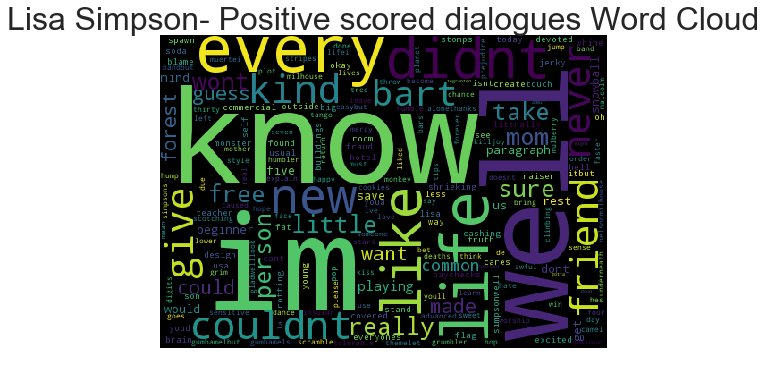

In [81]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_positive3.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Lisa Simpson- Positive scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

In [82]:
df_normalized_text_negative3=df_normalized_text3.tail(20)
df_normalized_text_negative3

,raw_character_text,normalized_text,normalized_text_stem,sentiment_score
9960,Lisa Simpson,thanks but lowering your voice and standing on...,thank but lower your voic and stand on paint c...,-1.0
5863,Lisa Simpson,aw life on the lam is really hard but at least...,aw life on the lam is realli hard but at least...,-1.0
10533,Lisa Simpson,but when i grow up ill find other weird kids a...,but when i grow up ill find other weird kid an...,-1.0
8842,Lisa Simpson,but dad it defeats the purpose if youre poweri...,but dad it defeat the purpos if your power our...,-1.0
6175,Lisa Simpson,im not that cool i dont wear jeans ive polishe...,im not that cool i dont wear jean ive polish a...,-1.0
7325,Lisa Simpson,and i did get better at math but it was only b...,and i did get better at math but it wa onli by...,-1.0
4321,Lisa Simpson,we are a town of low-brows no-brows and ignora...,we are a town of low-brow no-brow and ignorami...,-1.0
419,Lisa Simpson,im sorry bart but if you got hurt or died desp...,im sorri bart but if you got hurt or die despi...,-1.0
2545,Lisa Simpson,i admit i havent known mom as long as you have...,i admit i havent known mom as long as you have...,-1.0
3456,Lisa Simpson,quite preposterous but no one will believe me ...,quit preposter but no one will believ me until...,-1.0


(-0.5, 499.5, 349.5, -0.5)

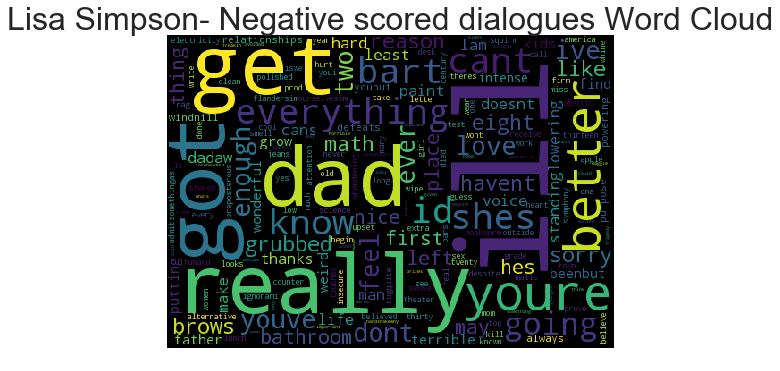

In [83]:
my_stopwords=set(stopwords.words('english'))
text_list = [];
json_str= df_normalized_text_negative3.to_json(orient='records')
 
json_obj = json.loads(json_str); 
text_list = [];
for data in json_obj:
        text_list.append(data.get('normalized_text'));

character_text = ''.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Lisa Simpson- Negative scored dialogues Word Cloud', fontsize=32)
plt.axis("off")

Overall analysis of series

In [84]:
def sentiment_score_to_category(score):
    if(score>0):
        return 'positive'
    if(score<0):
        return 'negative'
    if(score==0):
        return 'neutral'

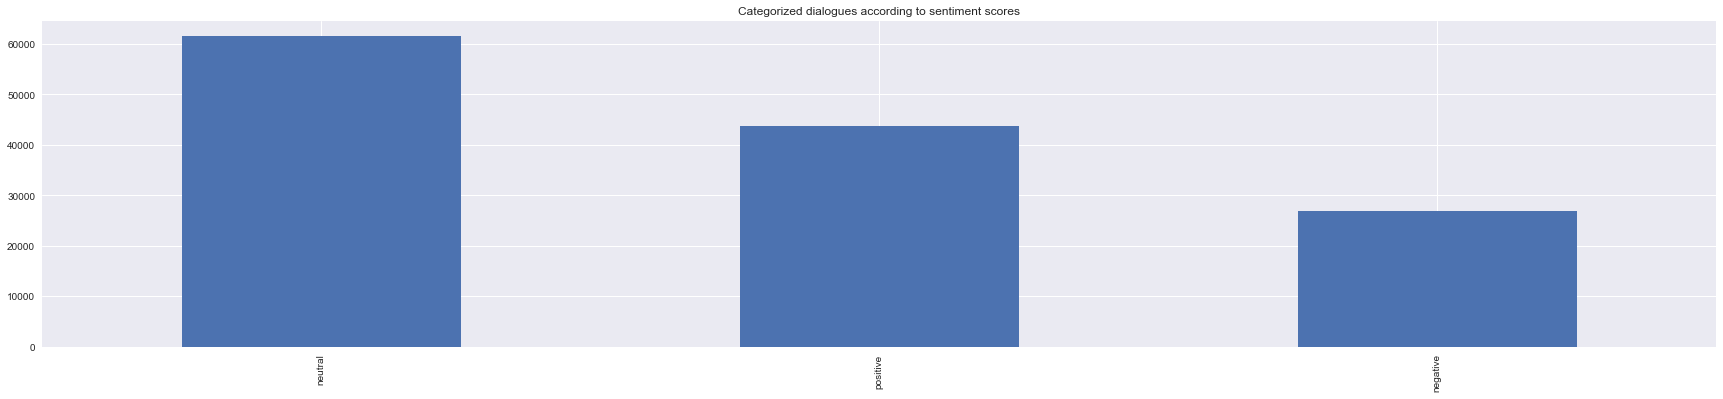

In [85]:
df_all_epsiode_dialogues['category'] =  df_all_epsiode_dialogues['sentiment_score'].map(sentiment_score_to_category)

df_all_epsiode_dialogues['category'].value_counts().plot(kind='bar')
plt.rcParams['figure.figsize'] = (30, 7)
plt.title('Categorized dialogues according to sentiment scores')
plt.show()

In [86]:
df_normalized_text_filtered_category=df_all_epsiode_dialogues[df_all_epsiode_dialogues.category!='neutral']

In [87]:
df_normalized_text_filtered_category.head()

,episode_id,character_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score,category
3156,12,153,196.0,this is all very exciting but i think wed do w...,Sideshow Bob,Sideshow Bob's Dressing Room,thi is all veri excit but i think wed do well ...,1.0,positive
16373,63,210,5.0,but first lets join the new little miss spring...,Scott Christian,Simpson Home,but first let join the new littl miss springfi...,1.0,positive
35431,146,139,5.0,well itchy and scratchy are gone but heres a c...,Krusty the Clown,Simpson Home,well itchi and scratchi are gone but here a ca...,1.0,positive
35675,147,1923,1427.0,yeah but for a role like this you gotta pour i...,Macarthur Parker,TROY'S LIVING ROOM,yeah but for a role like thi you gotta pour it...,1.0,positive
100864,425,11,904.0,wordplay never cared for it but its never too ...,Ned Flanders,FLANDERS CAR,wordplay never care for it but it never too so...,1.0,positive


In [88]:
#RUn thsi until we obtain only 2 columns as below
df_normalized_text_filtered_category=df_normalized_text_filtered_category.drop(df_normalized_text_filtered_category.columns[1],axis=1)

In [89]:
df_normalized_text_filtered_category.head(1)

,episode_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score,category
3156,12,196.0,this is all very exciting but i think wed do w...,Sideshow Bob,Sideshow Bob's Dressing Room,thi is all veri excit but i think wed do well ...,1.0,positive


In [90]:
df_normalized_text_filtered_category['count'] = df_normalized_text_filtered_category.groupby(['raw_character_text', 'category'])['category'].transform(lambda x: x.count())
a =df_normalized_text_filtered_category.groupby([ 'category', 'count']).apply(lambda x: x.sort_values('raw_character_text')).reset_index(drop=True)
a.drop_duplicates(subset=['raw_character_text', 'category', 'count'], keep='first', inplace=True)


In [91]:
a.head(5)

,episode_id,location_id,normalized_text,raw_character_text,raw_location_text,normalized_text_stem,sentiment_score,category,count
0,530,4234.0,fat daddy smell like beer,1-Year-Old Bart,OUTDOOR MALL,fat daddi smell like beer,-0.2023,negative,1
1,333,2786.0,what bills we got no water no heat we catch ou...,10-Year-Old Carl,Motorboat,what bill we got no water no heat we catch our...,-0.5267,negative,1
2,387,6.0,marjorie we need to hide our cigarettes in you...,13-Year-Old Patty,KITCHEN,marjori we need to hide our cigarett in your d...,-0.1779,negative,1
3,391,307.0,as hall monitor i am the law no running in the...,16-Year-Old Wiggum,Springfield High School,as hall monitor i am the law no run in the hal...,-0.6808,negative,1
4,169,1574.0,thanks for driving me big brother these giant ...,1986 Cecil,Cecil's Brownstone Apartment,thank for drive me big brother these giant clo...,-0.8908,negative,1


This has given just a count of positive and negative dialogues spoken per character

We have thus analyzed the sentiments of the series episode wise and character wise. 

After understanding the context the results seem to be close to accurate.  

Also, we now know that how many positive or negative dialoguesa character has spoken in the series 

We have also seen the word clouds for most positive and negative rated sentences

Now, let us make some analysis based on location




**Homer Simpsons Locations**

In [92]:
df_most_active_locations = pd.read_sql("select location_name , raw_character_text, count(normalized_text) from Script_Lines inner join  locations on locations.id=Script_Lines.location_id where raw_character_text='Homer Simpson' group by location_name order by 3 desc limit 20", con=connection);

In [93]:
df_most_active_locations.head(5)

,location_name,raw_character_text,count(normalized_text)
0,Simpson Home,Homer Simpson,9714
1,Moe's Tavern,Homer Simpson,1025
2,Springfield Nuclear Power Plant,Homer Simpson,1009
3,Simpson Car,Homer Simpson,371
4,Simpson Living Room,Homer Simpson,323


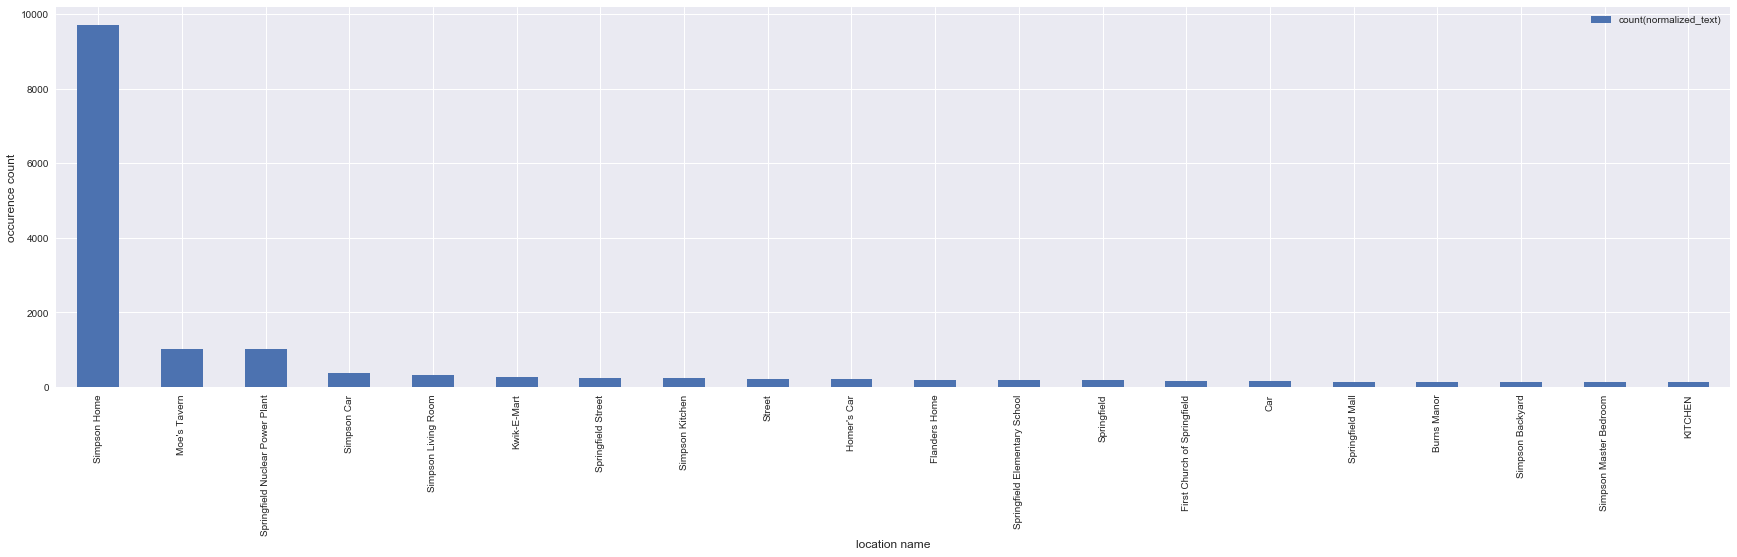

In [95]:
ax = df_most_active_locations.plot(x='location_name',y='count(normalized_text)',kind='bar')
ax.set_ylabel("occurence count", fontsize=12)
ax.set_xlabel("location name", fontsize=12)
plt.show()

The top 5 active location of Homer seems to be as above.
Let us analyis further on the positivity and negativity of sentiments based on location

In [96]:
df_normalized_text_homer = pd.read_sql("select raw_character_text,raw_location_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Homer Simpson') and raw_location_text='Simpson Home'",con=connection);

In [97]:
df_normalized_text_homer.head(10)

,raw_character_text,raw_location_text,normalized_text
0,Homer Simpson,Simpson Home,marge havent you finished that stupid letter yet
1,Homer Simpson,Simpson Home,marge
2,Homer Simpson,Simpson Home,marge wheres the extension cord
3,Homer Simpson,Simpson Home,sorry im just a big kid and i love christmas s...
4,Homer Simpson,Simpson Home,every year
5,Homer Simpson,Simpson Home,a what
6,Homer Simpson,Simpson Home,yeah if you want one youll have to pay for it ...
7,Homer Simpson,Simpson Home,yello
8,Homer Simpson,Simpson Home,whos this
9,Homer Simpson,Simpson Home,this is her sister isnt it


In [98]:
df_normalized_text_homer ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text_homer ['normalized_text']]
df_normalized_text_homer ['sentiment_score'] =  df_normalized_text_homer ['normalized_text_stem'].map(polarity_scores)
df_normalized_text_homer=df_normalized_text_homer.sort_values(by=['sentiment_score'], ascending=False)
df_normalized_text_homer['sentiment'] =  df_normalized_text_homer['sentiment_score'].map(sentiment_score_to_category)

In [99]:
df_normalized_text_homer=df_normalized_text_homer[df_normalized_text_homer['sentiment_score']!=0]
df_normalized_text_homer.head(5)

,raw_character_text,raw_location_text,normalized_text,normalized_text_stem,sentiment_score,sentiment
657,Homer Simpson,Simpson Home,yeah probably anyway once upon a time there wa...,yeah probabl anyway onc upon a time there wa a...,1.0,positive
656,Homer Simpson,Simpson Home,bart its not like im asking you to give blood ...,bart it not like im ask you to give blood for ...,1.0,positive
8808,Homer Simpson,Simpson Home,well to me it looks like garbage salad but tha...,well to me it look like garbag salad but that ...,1.0,positive
5368,Homer Simpson,Simpson Home,yep but youre still safe at home after a few p...,yep but your still safe at home after a few pr...,1.0,positive
3089,Homer Simpson,Simpson Home,whoa not me and not because johns gay but beca...,whoa not me and not becaus john gay but becaus...,1.0,positive


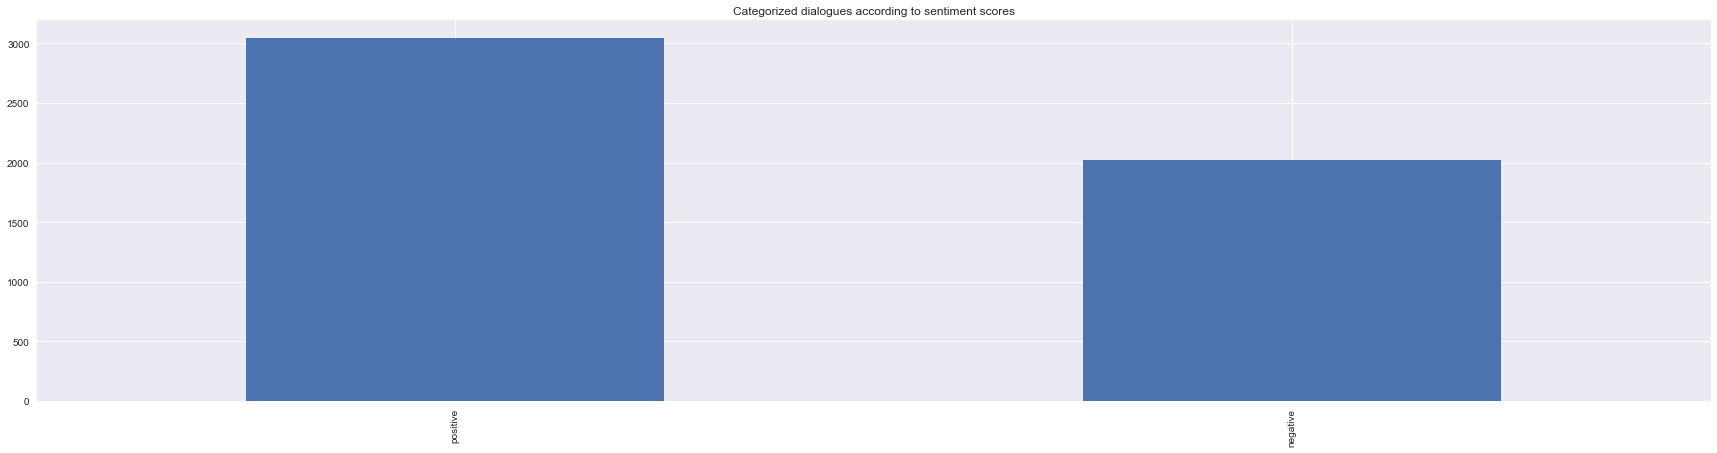

In [100]:
#df_all_epsiode_dialogues['category'] =  df_all_epsiode_dialogues['sentiment_score'].map(sentiment_score_to_category)
df_normalized_text_homer['sentiment'].value_counts().plot(kind='bar')
plt.rcParams['figure.figsize'] = (10, 3)
plt.title('Categorized dialogues according to sentiment scores')
plt.show()

Let us analyse some positive n negative words spoken by Homer Simpson

In [101]:
df_normalized_text = pd.read_sql("select raw_character_text, normalized_text from script_lines where speaking_line='True' and raw_character_text in ('Homer Simpson')",con=connection);
df_normalized_text ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_normalized_text ['normalized_text']]

In [104]:
df_normalized_text.head(5)

,raw_character_text,normalized_text,normalized_text_stem
0,Homer Simpson,theres no time to be careful,there no time to be care
1,Homer Simpson,were late,were late
2,Homer Simpson,hey norman hows it going so you got dragged do...,hey norman how it go so you got drag down here...
3,Homer Simpson,pardon my galoshes,pardon my galosh
4,Homer Simpson,oh its lisa thats ours,oh it lisa that our


In [105]:
all_words_homer=[" ".join(df_normalized_text['normalized_text_stem'])]
all_words_homer=clean_text(all_words_homer)
all_words_homer=removeDuplicates(all_words_homer)
all_words_homer

'time care late hey norman go got drag heh ya fred excus pardon galosh oh lisa mani grade doe thi school marg havent finish stupid letter yet extens cord sorri im big kid love christma much everi year yeah want one youll pay allow yello sister isnt shall say call okay prepar dazzl turn juic think flander bright show-off spill hide money jar mm-hmm mmm-hmm thank god true empti ruin cancel present anyon bonu silli thisll best ani famili ever heh-heh good becaus dont deserv guy fat wallet credit card wont set horribl beep well let honest shop see oooh look pantyhos practic allur six-pack onli four nineti nine pad paper bet bart million thing leav littl maggi squeak-toy dog cant read hello theyr gimm moe crazi getup barn wow mean even nut certainli huh get paid dasher dancer prancer nixon comet cupid donna dixon would like boy whi egghead knew word head straight tub patti selma wa trip merri way uh-oh beauti ornament ah son need junk sure youv alreadi someth import decent home father anyth

In [106]:
df_homer_words=all_words_homer.split(" ")
#df_homer_words

In [107]:
new_dict = {k: lex_dict[k] for k in df_homer_words if k in lex_dict}

Word cloud of the words by Homer Simpson

(-0.5, 499.5, 349.5, -0.5)

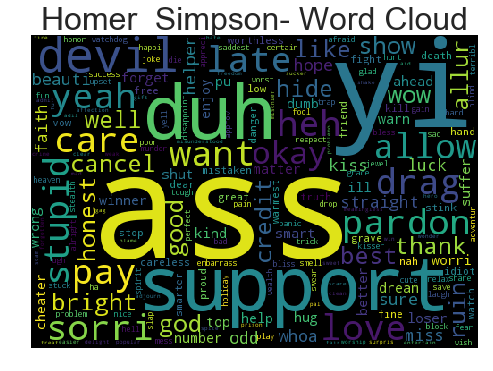

In [108]:
my_stopwords=set(stopwords.words('english'))
text_list = new_dict.keys();

character_text = ' '.join(text_list); 
wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=my_stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
wc.generate(character_text);


fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(wc)
plt.title('Homer  Simpson- Word Cloud', fontsize=32)
plt.axis("off")

In [109]:
sorted_words = [(k,v) for v,k in sorted([(v,k) for k,v in new_dict.items()])]
sorted_words
p1 = dict((key, value) for key, value in new_dict.items() if value > 3)


In [110]:
p1

{'best': 3.2,
 'freedom': 3.2,
 'great': 3.1,
 'greatest': 3.2,
 'happiest': 3.2,
 'love': 3.2,
 'sweetheart': 3.3,
 'yessir': 4.0}

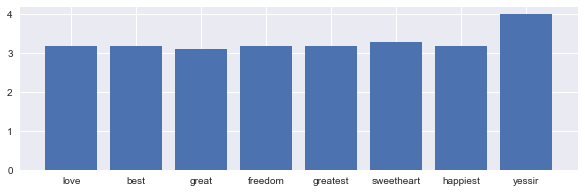

In [111]:
plt.bar(range(len(p1)), p1.values(), align="center")
plt.xticks(range(len(p1)), list(p1.keys()))
plt.show()

The above seems to be the most positive words spoken by Homer

In [112]:
p2 = dict((key, value) for key, value in new_dict.items() if value < -3)

In [113]:
p2

{'apocalyps': -3.6,
 'betray': -3.2,
 'brutal': -3.1,
 'dead': -3.3,
 'devil': -3.4,
 'dyin': -3.8,
 'evil': -3.4,
 'fu': -3.7,
 'hell': -3.6,
 'kill': -3.7,
 'killer': -3.3,
 'murder': -3.7,
 'scumbag': -3.2,
 'terrorist': -3.7,
 'vile': -3.1,
 'whore': -3.3,
 'worst': -3.1}

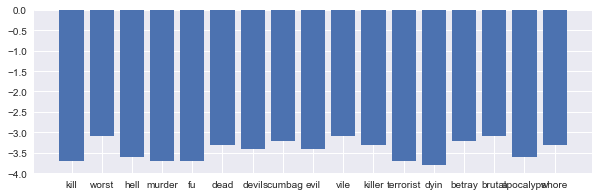

In [114]:
plt.bar(range(len(p2)), p2.values(), align="center")
plt.xticks(range(len(p2)), list(p2.keys()))
plt.show()

Above are the most negative or harsh words spoken by Homer

Characters sentiments towards each other

For determining the sentiments of characters towards each other, we need to make few assumptions.
It is assumed that characters who spoke immediately before and after each other express sentiments towards each other.
This assumption is not always true but for basic analysis, we will go about this assumption.


In [115]:
import pandas as pd
df_character_communication=pd.read_csv('~/Desktop/Simpsons Project/Datasets/characters_communication.csv',sep=',', delimiter=None)
df_character_communication.head()

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to
0,464,Miss Hoover,no actually it was a little of both sometimes ...,9.0,Lisa Simpson
1,9,Lisa Simpson,wheres mr bergstrom,464.0,Miss Hoover
2,464,Miss Hoover,i dont know although id sure like to talk to h...,9.0,Lisa Simpson
3,9,Lisa Simpson,that life is worth living,40.0,Edna Krabappel-Flanders
4,40,Edna Krabappel-Flanders,the polls will be open from now until the end ...,38.0,Martin Prince


From the exploratory, we have determined that Mr Burns, Moe, Ned Flanders, Skinner, Grampa Simpson are the main supporting characters
So, we can analyse their sentiments towards Simpsons family members

In [116]:
df_character_Burns=df_character_communication[df_character_communication['character_id_from']==15] 
#and (character_id_to ==2 or character_id_to ==1 or character_id_to ==8  or character_id_to == 9 )]
#df_character_Burns=df_character_communication[(df_character_communication['character_id_to'] ==1)] 

In [117]:
df_character_Burns.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to
712,15,C. Montgomery Burns,must turn over got to greet dignitaries,14.0,Waylon Smithers
714,15,C. Montgomery Burns,absolutely not no quack sawbones is going to a...,332.0,Dr. Julius Hibbert
724,15,C. Montgomery Burns,smithers dont feel so bad after all that kidne...,2.0,Homer Simpson
780,15,C. Montgomery Burns,smithers im not going to make it i want to dic...,15.0,C. Montgomery Burns
781,15,C. Montgomery Burns,charles montgomery burns,14.0,Waylon Smithers


In [118]:
df_character_Burns = df_character_Burns[(df_character_Burns.character_id_to == 1) | (df_character_Burns.character_id_to == 2) | (df_character_Burns.character_id_to == 8)| (df_character_Burns.character_id_to == 9)]

In [119]:
df_character_Burns.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to
724,15,C. Montgomery Burns,smithers dont feel so bad after all that kidne...,2.0,Homer Simpson
790,15,C. Montgomery Burns,oh hey there mr brown shoes how about that loc...,2.0,Homer Simpson
800,15,C. Montgomery Burns,well the simpsons will be getting a very nice ...,2.0,Homer Simpson
870,15,C. Montgomery Burns,well countess van zeplin and i what in blaze n...,2.0,Homer Simpson
877,15,C. Montgomery Burns,chapter the fifth a trip to the infirmary with...,2.0,Homer Simpson


calculating sentiment score

In [120]:
df_character_Burns ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_character_Burns ['normalized_text']]
df_character_Burns ['sentiment_score'] =  df_character_Burns ['normalized_text_stem'].map(polarity_scores)
df_character_Burns=df_character_Burns.sort_values(by=['sentiment_score'], ascending=False)
df_character_Burns['sentiment'] =  df_character_Burns['sentiment_score'].map(sentiment_score_to_category)

In [121]:
df_character_Burns.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem,sentiment_score,sentiment
128201,15,C. Montgomery Burns,oooh a tough question but a fair one lisa ther...,9.0,Lisa Simpson,oooh a tough question but a fair one lisa ther...,1.0000,positive
128315,15,C. Montgomery Burns,hmmm crude but i like it what do you say we fr...,2.0,Homer Simpson,hmmm crude but i like it what do you say we fr...,0.9998,positive
120404,15,C. Montgomery Burns,i have embarked on a beneficial friendship wit...,2.0,Homer Simpson,i have embark on a benefici friendship with a ...,0.9997,positive
33127,15,C. Montgomery Burns,sir weve never met before but my name is mr bu...,2.0,Homer Simpson,sir weve never met befor but my name is mr bur...,0.9919,positive
45442,15,C. Montgomery Burns,well i will be when the morphine wears off but...,2.0,Homer Simpson,well i will be when the morphin wear off but u...,0.9871,positive


In [122]:
df_character_Burns['count'] = df_character_Burns.groupby(['raw_character_text_to', 'sentiment'])['sentiment'].transform(lambda x: x.count())
a =df_character_Burns.groupby([ 'sentiment', 'count']).apply(lambda x: x.sort_values('raw_character_text_to')).reset_index(drop=True)
a.drop_duplicates(subset=['raw_character_text_to', 'sentiment', 'count'], keep='first', inplace=True)


In [123]:
a.head(10)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem,sentiment_score,sentiment,count
0,15,C. Montgomery Burns,to show theres no hard feelings please take an...,8.0,Bart Simpson,to show there no hard feel pleas take an advan...,-0.0088,negative,23
23,15,C. Montgomery Burns,change course carol must be warned,1.0,Marge Simpson,chang cours carol must be warn,-0.1027,negative,26
49,15,C. Montgomery Burns,come on stand up do your trick,9.0,Lisa Simpson,come on stand up do your trick,-0.0516,negative,28
77,15,C. Montgomery Burns,oh dont be frightened of this its nothing but ...,2.0,Homer Simpson,oh dont be frighten of thi it noth but a lette...,-0.0001,negative,131
208,15,C. Montgomery Burns,so smithers it seems youve underestimated one ...,8.0,Bart Simpson,so smither it seem youv underestim one homer s...,0.0000,neutral,37
245,15,C. Montgomery Burns,set er down smithers,1.0,Marge Simpson,set er down smither,0.0000,neutral,41
286,15,C. Montgomery Burns,heave-ho heave-ho heave-ho heave-ho heave-ho,9.0,Lisa Simpson,heave-ho heave-ho heave-ho heave-ho heave-ho,0.0000,neutral,43
329,15,C. Montgomery Burns,merry humbug everyone,2.0,Homer Simpson,merri humbug everyon,0.0000,neutral,258
587,15,C. Montgomery Burns,now entering the ring the first family of foul...,8.0,Bart Simpson,now enter the ring the first famili of foul pl...,0.8591,positive,20
607,15,C. Montgomery Burns,listen spielbergo schindler and i are like pea...,1.0,Marge Simpson,listen spielbergo schindler and i are like pea...,0.9646,positive,24


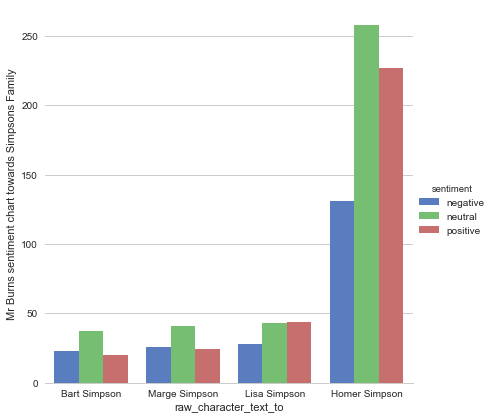

In [124]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="raw_character_text_to", y="count", hue="sentiment", data=a,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels(" Mr Burns sentiment chart towards Simpsons Family")

Mr Burns seem to have extremely positive sentiment towards Homer and seem to unline Bart and Marge

Checking sentiment based upon the sentiment scores

In [125]:
df_character_Skinner=df_character_communication[df_character_communication['character_id_from']==3] 
df_character_Skinner = df_character_Skinner[(df_character_Skinner.character_id_to == 1) | (df_character_Skinner.character_id_to == 2) | (df_character_Skinner.character_id_to == 8)| (df_character_Skinner.character_id_to == 9)]
df_character_Skinner ['normalized_text_stem'] =  [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df_character_Skinner ['normalized_text']]
df_character_Skinner.head(50)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem
1807,3,Seymour Skinner,ah here we are heres a whole box of unsealed e...,8.0,Bart Simpson,ah here we are here a whole box of unseal enve...
1809,3,Seymour Skinner,oh licking envelopes can be fun all you have t...,8.0,Bart Simpson,oh lick envelop can be fun all you have to do ...
1811,3,Seymour Skinner,well for example you could see how many you ca...,8.0,Bart Simpson,well for exampl you could see how mani you can...
1819,3,Seymour Skinner,you didnt believe me when i said it would be f...,8.0,Bart Simpson,you didnt believ me when i said it would be fu...
1823,3,Seymour Skinner,what,8.0,Bart Simpson,what
1825,3,Seymour Skinner,hmm well theres still a minute to go oh why no...,8.0,Bart Simpson,hmm well there still a minut to go oh whi not ...
1918,3,Seymour Skinner,whats this what are you boys doing,8.0,Bart Simpson,what thi what are you boy do
1985,3,Seymour Skinner,stop,1.0,Marge Simpson,stop
1993,3,Seymour Skinner,to get my mind off that ugly confrontation i w...,2.0,Homer Simpson,to get my mind off that ugli confront i went h...
2685,3,Seymour Skinner,your attention please this is principal skinne...,8.0,Bart Simpson,your attent pleas thi is princip skinner bart ...


In [126]:
df_character_Skinner ['sentiment_score'] =  df_character_Skinner ['normalized_text_stem'].map(polarity_scores)
df_character_Skinner=df_character_Skinner.sort_values(by=['sentiment_score'], ascending=False)
df_character_Skinner.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem,sentiment_score
56786,3,Seymour Skinner,but it wasnt clouds and angels playing harps l...,8.0,Bart Simpson,but it wasnt cloud and angel play harp like at...,1.0000
25505,3,Seymour Skinner,but our momentary lapse of concentration allow...,8.0,Bart Simpson,but our momentari laps of concentr allow charl...,1.0000
40361,3,Seymour Skinner,normally i wouldnt ask but its an emergency mo...,9.0,Lisa Simpson,normal i wouldnt ask but it an emerg mother ha...,1.0000
7845,3,Seymour Skinner,but first our second-prize winner and the reci...,2.0,Homer Simpson,but first our second-pr winner and the recipi ...,0.9999
126540,3,Seymour Skinner,well perhaps i was being a tad glib let me exp...,2.0,Homer Simpson,well perhap i wa be a tad glib let me explain ...,0.9999


In [127]:
#print(df_character_Skinner[df_character_Skinner['raw_character_text_to'] like'%Marge%Thoughts%'])

In [128]:
df_character_Skinner['sentiment'] =  df_character_Skinner['sentiment_score'].map(sentiment_score_to_category)
df_avg_character_Skinner=df_character_Skinner.groupby('raw_character_text_to', as_index=False)['sentiment_score'].mean()

In [129]:
df_avg_character_Skinner

,raw_character_text_to,sentiment_score
0,Bart Simpson,0.061081
1,Homer Simpson,0.031206
2,Lisa Simpson,0.095770
3,Marge Simpson,0.012282
4,Marge's Thoughts,0.318200


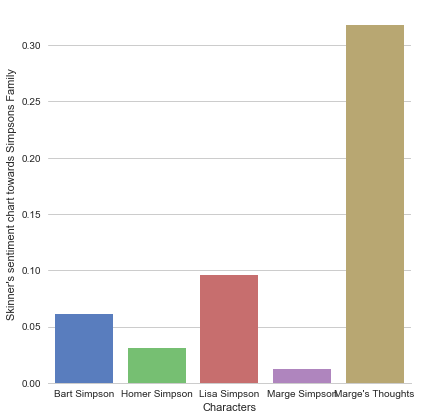

In [130]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="raw_character_text_to", y="sentiment_score",  data=df_avg_character_Skinner,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels(" Skinner's sentiment chart towards Simpsons Family")
g.set_xlabels("Characters")

In [131]:
df_character_Skinner.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem,sentiment_score,sentiment
56786,3,Seymour Skinner,but it wasnt clouds and angels playing harps l...,8.0,Bart Simpson,but it wasnt cloud and angel play harp like at...,1.0000,positive
25505,3,Seymour Skinner,but our momentary lapse of concentration allow...,8.0,Bart Simpson,but our momentari laps of concentr allow charl...,1.0000,positive
40361,3,Seymour Skinner,normally i wouldnt ask but its an emergency mo...,9.0,Lisa Simpson,normal i wouldnt ask but it an emerg mother ha...,1.0000,positive
7845,3,Seymour Skinner,but first our second-prize winner and the reci...,2.0,Homer Simpson,but first our second-pr winner and the recipi ...,0.9999,positive
126540,3,Seymour Skinner,well perhaps i was being a tad glib let me exp...,2.0,Homer Simpson,well perhap i wa be a tad glib let me explain ...,0.9999,positive


In [132]:
df_character_Skinner['count'] = df_character_Skinner.groupby(['raw_character_text_to', 'sentiment'])['sentiment'].transform(lambda x: x.count())
a =df_character_Skinner.groupby([ 'sentiment', 'count']).apply(lambda x: x.sort_values('raw_character_text_to')).reset_index(drop=True)
a.drop_duplicates(subset=['raw_character_text_to', 'sentiment', 'count'], keep='first', inplace=True)
a.head(5)

,character_id_from,raw_character_text_from,normalized_text,character_id_to,raw_character_text_to,normalized_text_stem,sentiment_score,sentiment,count
0,3,Seymour Skinner,gentlemen i cant run away from what ive done i...,1.0,Marge Simpson,gentlemen i cant run away from what ive done i...,-0.0258,negative,25
25,3,Seymour Skinner,well i see no way of settling this i say we im...,9.0,Lisa Simpson,well i see no way of settl thi i say we impris...,-0.0258,negative,38
63,3,Seymour Skinner,its when the jury cant agree on a verdict,2.0,Homer Simpson,it when the juri cant agre on a verdict,-0.0170,negative,40
103,3,Seymour Skinner,ill be back in three hours maybe less but almo...,8.0,Bart Simpson,ill be back in three hour mayb less but almost...,-0.0001,negative,70
173,3,Seymour Skinner,forward side together back side together forwa...,1.0,Marge Simpson,forward side togeth back side togeth forward s...,0.0000,neutral,21


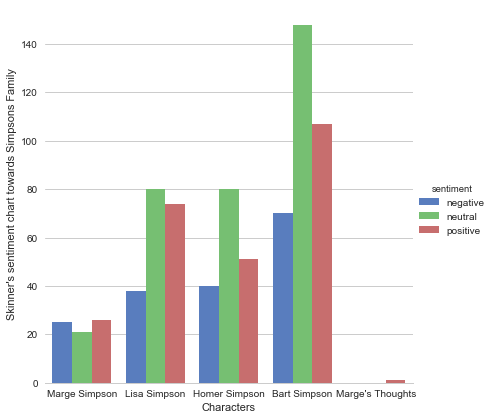

In [133]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="raw_character_text_to", y="count", hue="sentiment", data=a,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_xlabels("Characters")
g.set_ylabels(" Skinner's sentiment chart towards Simpsons Family")

Skinner seems to like Bart a lot from amongst the Simpons family.

Thus, in this notebook we were able to  analyse the sentiments of the entire series, episode wise analysis, character wise sentiments as well as sentiments of characters towars each other.

In the next notebook, we will run some classifiers over the data and check the accuracy of the classifiers